### show sensitivity to MERRA-2 snow, Jutila sea ice density, scaled snow

In [1]:
### all csv files used in this notebook are made in ../notebooks/sit_new_product.ipynb

In [2]:
import pandas as pd
import numpy as np
import itertools
import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

### load buoy and auxiliary data

In [3]:
moorings = ['sumata','a','b','d']

### calculate correlation and bias between mooring and cs2 anoms, over fyi and myi

In [4]:
thresholds =  np.arange(5,96,2.5)
alphas = np.round(np.arange(0,1.01,0.01),decimals=2)

In [5]:
rho_fyi = 916.7
rho_myi = 882.0

In [6]:
data_name = 'merra2'

In [7]:
cryo_dir = f'/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/alpha_sits_{data_name}'

r_values_dictionary_all = {} ; bias_dictionary_all = {} 

iterator = list(itertools.product(thresholds,alphas))

all_moorings = ['sumata','a','b','d']
aoo_moorings = ['sumata']
bgep_moorings = ['a','b','d']

for mooring_name, moorings in zip(['AOO','BGEP','Combined'],[aoo_moorings,bgep_moorings,all_moorings]):
    r_values_dictionary = {} ; bias_dictionary = {} 

    for threshold, alpha in tqdm.tqdm(iterator):

        values = [] 

        for mooring in moorings:

            cryosat_df = pd.read_csv(f'{cryo_dir}/a{alpha}_{mooring}.csv')

            for month, year in zip(cryosat_df['month'],cryosat_df['year']):

                df_cs2_mon_year = cryosat_df[(cryosat_df['month']==month) & (cryosat_df['year']==year)]

                cs2_value = df_cs2_mon_year[f'mean_sit_{threshold}'].iloc[0]
                mooring_value = df_cs2_mon_year['mean_buoy_thickness'].iloc[0]

                values.append({"year":year,"month":month,"cryosat_thickness":cs2_value,
                                "mooring_thickness":mooring_value,"mooring":mooring})
 
        values_df = pd.DataFrame(values)


        df_anoms = {} ; mooring_anoms = [] ; cryosat_anoms = []
        for mooring in moorings: ### calculate anoms for each mooring 

            mooring_df = values_df[values_df['mooring']==mooring]

            months = set(mooring_df['month'])

            mooring_climatologies = {} ; cryosat_climatologies = {}

            for month in months:
                df_cs2_mon = mooring_df['cryosat_thickness'][mooring_df['month']==month]
                df_mooring_mon = mooring_df['mooring_thickness'][mooring_df['month']==month]

                cryosat_climatologies[month] = np.nanmean(df_cs2_mon)
                mooring_climatologies[month] = np.nanmean(df_mooring_mon)

            monthly_bias = []

            for month, cs2_sit, mooring_sit in zip(mooring_df['month'],mooring_df['cryosat_thickness'],
                                                   mooring_df['mooring_thickness']):
                mooring_anoms.append(mooring_sit-mooring_climatologies[month])
                cryosat_anoms.append(cs2_sit-cryosat_climatologies[month])
                monthly_bias.append(cs2_sit-mooring_sit)

        df_anoms['mooring_anom'] = mooring_anoms ### combine anoms from moorings into one dataframe
        df_anoms['cryosat_anom'] = cryosat_anoms

        c = np.array(df_anoms['cryosat_anom']) ### calculate correlation between moorings and cs2
        m = np.array(df_anoms['mooring_anom'])
        df = pd.DataFrame({'c':c,'m':m}).dropna()
        
        if (threshold == 5) & (alpha == 0):
            print(mooring_name,len(df['m']))

        lr = linregress(df['c'],df['m'])
        pvalue = lr[3]
        pearsonr = lr[2] if pvalue < 0.05 else np.nan

        r_values_dictionary[(threshold,alpha)] = pearsonr
        bias_dictionary[(threshold,alpha)] = np.nanmean(monthly_bias)
            
    r_values_dictionary_all[mooring_name] = r_values_dictionary
    bias_dictionary_all[mooring_name] = bias_dictionary

  0%|                                          | 5/3737 [00:00<01:25, 43.81it/s]

AOO 63


  0%|                                          | 4/3737 [00:00<04:01, 15.46it/s]

BGEP 216


  0%|                                          | 2/3737 [00:00<05:08, 12.12it/s]

Combined 279


100%|███████████████████████████████████████| 3737/3737 [05:11<00:00, 11.98it/s]


In [8]:
r_values_dict = {} ; biases_dict = {}

for mooring_name in ['AOO','BGEP','Combined']:
    
    r_values_dictionary = r_values_dictionary_all[mooring_name]
    bias_dictionary = bias_dictionary_all[mooring_name]

    r_values_matrix = np.full((len(thresholds),len(alphas)),np.nan)
    bias_matrix = np.full((len(thresholds),len(alphas)),np.nan)

    for tcounter, thresh in enumerate(thresholds):

        for acounter, alpha in enumerate(alphas):

            r_val = r_values_dictionary[(thresh,alpha)] 
           
            bias = bias_dictionary[(thresh,alpha)] 

#             if (thresh == 80) & (alpha==0.8):

#                 r_val = 1

            r_values_matrix[tcounter,acounter] = r_val
            bias_matrix[tcounter,acounter] = bias
            
    r_values_matrix[r_values_matrix<0] = np.nan
    
    r_values_dict[mooring_name] = r_values_matrix
    biases_dict[mooring_name] = bias_matrix

### plot bias and correlation heatmap for AOO, BGEP and Combined

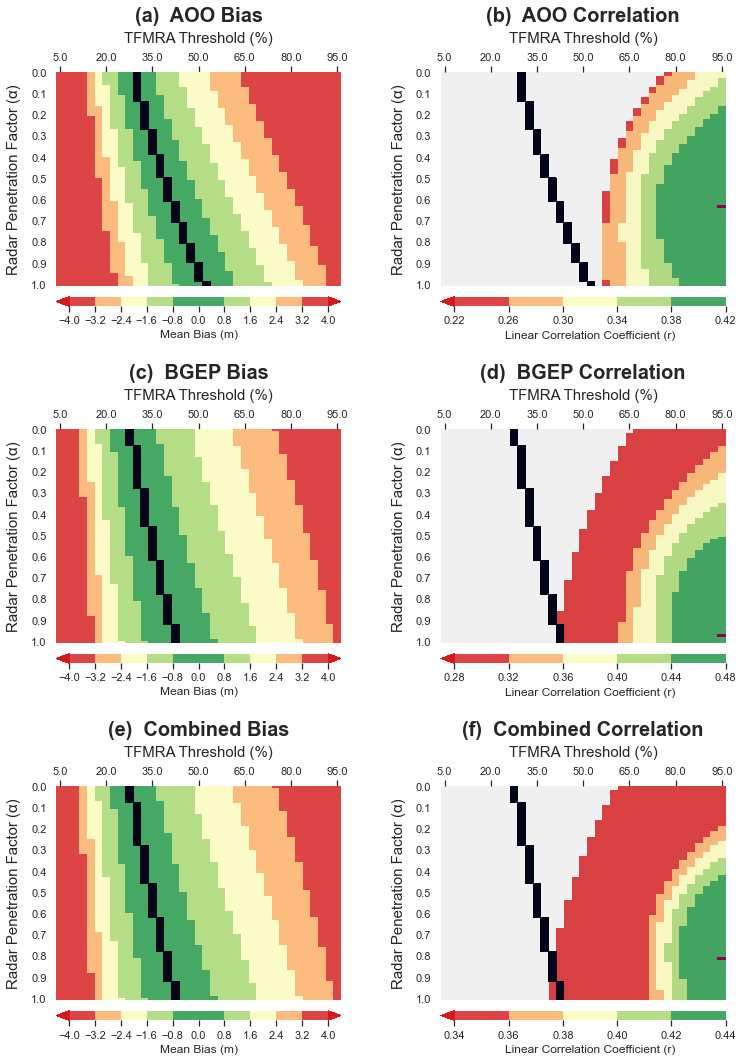

In [9]:
fig = plt.figure(figsize=(12,18))
spec = gridspec.GridSpec(ncols=2, nrows=3,wspace=0.35,hspace=0.35)
plt.rc('font', size=10)
plt.rcParams.update({'hatch.color': 'black'})
sns.set(rc={'axes.facecolor':'#f0f0f0'})
nums = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ']

a00_ticks = [0.22,0.26,0.3,0.34,0.38,0.42]
bgep_ticks = [0.28,0.32,0.36,0.4,0.44,0.48]
combined_ticks = [0.34,0.36,0.38,0.4,0.42,0.44]

k = 0
for mooring_name,limit,ticks in zip(['AOO','BGEP','Combined'],[[0.22,0.42],[0.28,0.48],[0.34,0.44]],
                            [a00_ticks,bgep_ticks,combined_ticks]):

    ### bias heatmap
    bias_df = pd.DataFrame(biases_dict[mooring_name].T,columns=thresholds,index=alphas)
    ax1 = fig.add_subplot(spec[k])
    list_colors = ['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641','#1a9641','#a6d96a','#ffffbf','#fdae61','#d7191c']
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 10)
    bias_ticks = [-4,-3.2,-2.4,-1.6,-0.8,0,0.8,1.6,2.4,3.2,4]
    label = 'Mean Bias (m)'
    ax1 = sns.heatmap(bias_df, cmap=cm, annot=False, vmin=-4,vmax=4,yticklabels=10,cbar=True,alpha=0.8,
                      xticklabels=6,cbar_kws={'location': 'bottom','extend': 'both',"ticks":bias_ticks,"aspect":30,
                                              "label":label,"pad": 0.04})
    ### calculate mins line
    mins = np.full((biases_dict[mooring_name].T.shape),np.nan)

    for alpha in np.arange(0,len(mins)):
        min = np.nanargmin(np.abs(biases_dict[mooring_name][:,alpha]))
        mins[alpha,min] = 1
    x = np.arange(0,len(thresholds)+1)
    y = np.arange(0,len(alphas)+1)
    ax1.pcolor(x, y, mins)

    ax1.tick_params(axis='y', labelrotation=0)
    ax1.set_ylabel('Radar Penetration Factor (\u03B1)',labelpad=10,fontsize=15)
    ax1.set_xlabel('TFMRA Threshold (%)',labelpad=10,fontsize=15)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_title(f'{nums[k]} {mooring_name} Bias',fontweight='bold',fontsize=20,pad=10)
    

    k+=1
    
    ### correlation 
    rs_df = pd.DataFrame(r_values_dict[mooring_name].T,columns=thresholds,index=alphas)
    ax2 = fig.add_subplot(spec[k])
    list_colors = ['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641'] 
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 5)
    list_colors_mask = ['gainsboro','gainsboro'] 
    cm_mask = LinearSegmentedColormap.from_list('map', list_colors_mask, N = 2)
    mask = r_values_dict[mooring_name].T.copy()
    mask[np.isnan(mask)] = 1000
    mask[mask<1000] = 0
    label = 'Linear Correlation Coefficient (r)'
    ax2 = sns.heatmap(rs_df, cmap=cm_mask, annot=False, annot_kws={'color': 'k'},fmt=".2f", 
                      xticklabels=10,cbar=False,)
    
    ax2 = sns.heatmap(rs_df, cmap=cm, mask=mask,annot=False, linewidths=0,cbar=True, alpha=0.8,vmin=limit[0],
                      vmax=limit[1],yticklabels=10,xticklabels=6,cbar_kws={'location': 'bottom','extend': 'min',
                      "aspect":30,"label":label,"pad": 0.04,"ticks": ticks})

     ### plot min line
    ax2.pcolor(x, y, mins)
    
    ### calculate highest correlation
    maxs = r_values_dict[mooring_name].T.copy()
    max = np.nanmax(r_values_dict[mooring_name])
    maxs[maxs==max] = 1
    maxs[maxs<max] = np.nan
    ax2.pcolor(x, y, maxs,cmap='PiYG')
    
    ax2.tick_params(axis='y', labelrotation=0)
    ax2.set_xlabel('TFMRA Threshold (%)',labelpad=10,fontsize=15)
    ax2.set_ylabel('Radar Penetration Factor (\u03B1)',labelpad=10,fontsize=15)

    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_title(f'{nums[k]} {mooring_name} Correlation',fontweight='bold',fontsize=20,pad=10)

    k+=1

figpath = '/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/bias_corr_merra2.jpg'
plt.savefig(figpath,bbox_inches = "tight", dpi = 400)

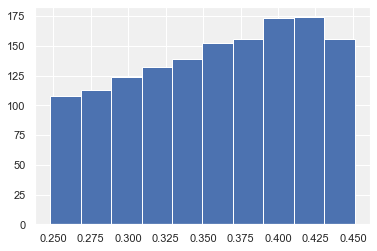

(0.35798496457980716, 0.24804581184032046, 0.45119238062317185)

In [10]:
mooring_name = 'AOO'
plt.hist(r_values_dict[mooring_name].ravel())
plt.show()
np.nanmean(r_values_dict[mooring_name]),np.nanmin(r_values_dict[mooring_name]),np.nanmax(r_values_dict[mooring_name])

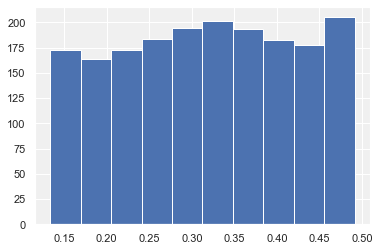

(0.3171858728853263, 0.13363343190307259, 0.4915619940400637)

In [11]:
mooring_name = 'BGEP'
plt.hist(r_values_dict[mooring_name].ravel())
plt.show()
np.nanmean(r_values_dict[mooring_name]),np.nanmin(r_values_dict[mooring_name]),np.nanmax(r_values_dict[mooring_name])

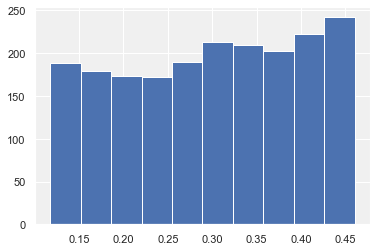

(0.2984077957831061, 0.11751990515902208, 0.46046569523594205)

In [12]:
mooring_name = 'Combined'
plt.hist(r_values_dict[mooring_name].ravel())
plt.show()
np.nanmean(r_values_dict[mooring_name]),np.nanmin(r_values_dict[mooring_name]),np.nanmax(r_values_dict[mooring_name])